[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1NZBq4g0oxL_RvmdzfBINscouUXmAbWnb?usp=sharing)

## Transfer Learning using TensorFlow Hub

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pylab as plt
import datetime

In [ ]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228813984/228813984 [==============================] - 3s 0us/step


In [ ]:
data_dir

'/root/.keras/datasets/flower_photos'

In [ ]:
!ls -lrt /root/.keras/datasets/flower_photos

total 612
-rw-r----- 1 270850 5000 418049 Feb  9  2016 LICENSE.txt
drwx------ 2 270850 5000  36864 Feb 10  2016 tulips
drwx------ 2 270850 5000  40960 Feb 10  2016 sunflowers
drwx------ 2 270850 5000  36864 Feb 10  2016 roses
drwx------ 2 270850 5000  53248 Feb 10  2016 dandelion
drwx------ 2 270850 5000  36864 Feb 10  2016 daisy


In [ ]:
img_height = 224
img_width = 224
BATCH_SIZE = 128

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_dir),
  validation_split=0.2,
  subset="training",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_dir),
  validation_split=0.2,
  subset="validation",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE
)

class_names = np.array(train_ds.class_names)
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


## Using TensorFlow Hub

In [ ]:
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = inception_v3

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

10484/10484 [==============================] - 0s 0us/step


23/23 [==============================] - 28s 575ms/step


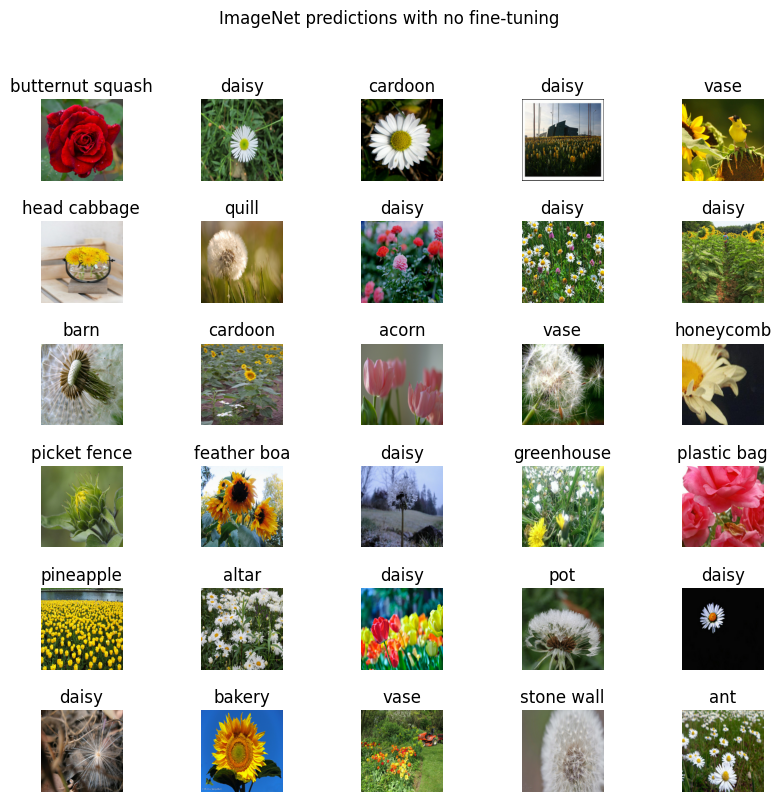

In [ ]:
result_batch = classifier.predict(train_ds)
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions with no fine-tuning")

In [ ]:
feature_extractor_model = inception_v3

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [ ]:
NUM_CLASSES = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(NUM_CLASSES)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              23853833  
                                                                 
 dense (Dense)               (None, 5)                 5010      
                                                                 
Total params: 23858843 (91.01 MB)
Trainable params: 5010 (19.57 KB)
Non-trainable params: 23853833 (91.00 MB)
_________________________________________________________________


In [ ]:
pred = model(image_batch)

In [ ]:
pred.shape

TensorShape([128, 5])

## Train model

In [ ]:
NUM_EPOCHS = 10

model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS).history

Epoch 1/10
23/23 [==============================] - 23s 766ms/step - loss: 1.3993 - acc: 0.5535 - val_loss: 0.8615 - val_acc: 0.7221
Epoch 2/10
23/23 [==============================] - 8s 343ms/step - loss: 0.6241 - acc: 0.7844 - val_loss: 0.6528 - val_acc: 0.7929
Epoch 3/10
23/23 [==============================] - 8s 333ms/step - loss: 0.4731 - acc: 0.8294 - val_loss: 0.5730 - val_acc: 0.8093
Epoch 4/10
23/23 [==============================] - 8s 333ms/step - loss: 0.3968 - acc: 0.8600 - val_loss: 0.5334 - val_acc: 0.8174
Epoch 5/10
23/23 [==============================] - 7s 321ms/step - loss: 0.3485 - acc: 0.8753 - val_loss: 0.5095 - val_acc: 0.8229
Epoch 6/10
23/23 [==============================] - 7s 318ms/step - loss: 0.3136 - acc: 0.8879 - val_loss: 0.4935 - val_acc: 0.8311
Epoch 7/10
23/23 [==============================] - 8s 371ms/step - loss: 0.2871 - acc: 0.8995 - val_loss: 0.4822 - val_acc: 0.8311
Epoch 8/10
23/23 [==============================] - 7s 318ms/step - loss: 0

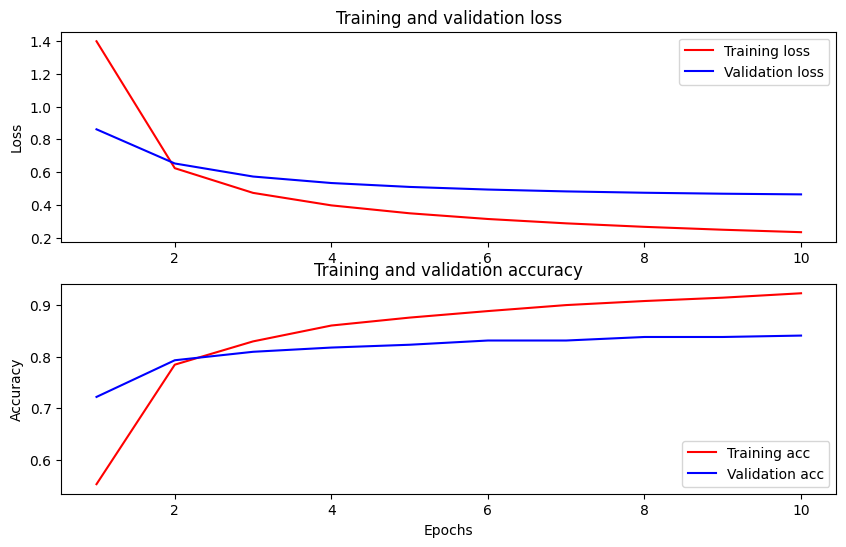

In [ ]:
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Check predictions

In [ ]:
image_batch, labels = next(iter(val_ds))

predicted_batch = model.predict(image_batch)
predicted_batch

4/4 [==============================] - 4s 50ms/step


array([[-5.3719363 , -3.7004902 , -1.1311204 , -2.5878267 ,  6.4901385 ],
       [-4.553545  , -3.567766  ,  4.50516   ,  3.8527434 ,  3.0552375 ],
       [-2.1394906 ,  3.635782  , -3.4253247 , -2.4551048 , -2.4694617 ],
       [ 6.1704216 , -1.8735799 , -6.063711  , -1.2148643 , -4.5163465 ],
       [-5.791008  ,  0.17473538, -0.19806883,  2.5844502 , -1.4680283 ],
       [-1.1777762 , -3.379414  , -0.6243935 , -0.8537232 ,  3.9888608 ],
       [-0.6771572 , -2.4633715 , -2.619627  ,  4.69399   , -5.762982  ],
       [ 3.9049418 , -0.3973067 , -5.281206  ,  0.19465181, -1.9507115 ],
       [-2.8192747 , -2.4186587 ,  2.8947291 ,  0.31471303,  4.1124253 ],
       [-1.5081719 ,  0.61627597, -2.8642857 ,  3.515723  , -1.8460757 ],
       [-2.5985365 , -2.3747873 ,  1.5273231 ,  3.1107786 ,  3.6877482 ],
       [-0.49328858, -1.1242661 ,  0.040535  , -0.18931076,  4.8560133 ],
       [-1.4261472 , -0.01633809, -2.0175464 ,  3.056912  , -0.651716  ],
       [-4.0777903 , -3.211218  , -0.9

In [ ]:
predicted_batch.shape

(128, 5)

In [ ]:
class_names

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

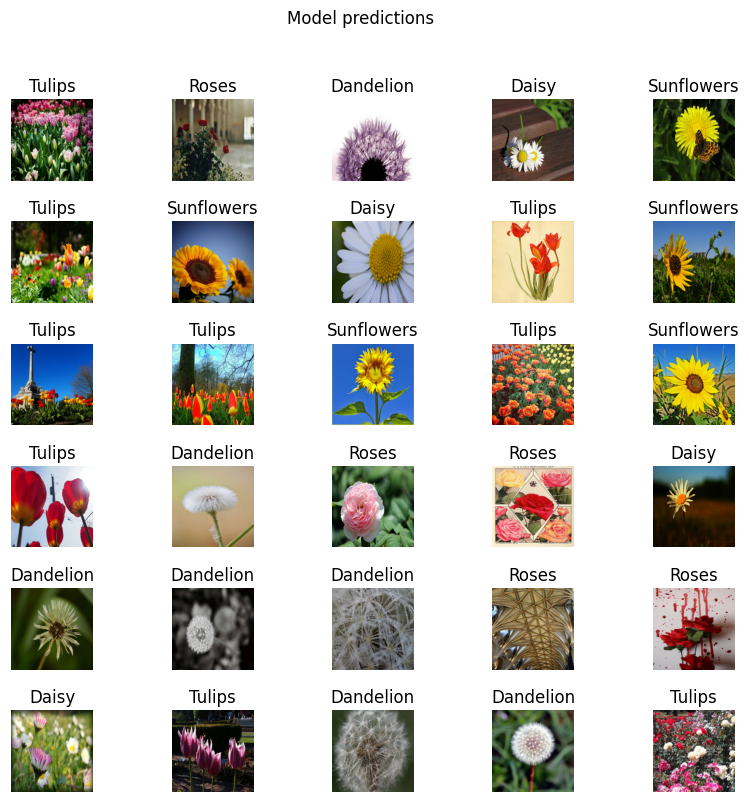

In [ ]:
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")